In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn
seaborn.set_style('white')
import hoag  
import mod_l_exp.utils as mlx
import numpy as np

### GENERATE DATASET

In [2]:
dataset = mlx.generate_multiclass_dataset(n_samples=90000, n_features=1000, n_informative=50, n_redundant=25, n_repeated=0,
                                      n_classes=2, n_clusters_per_class=3,
                                      flip_y=0.1, class_sep=1.0,
                                      random_state=1, hot_encoded=False, partitions_proportions=[1/3, 1/3])

datasets.redivide_data:, computed partitions numbers - [0, 30000, 60000, 90000] len all 90000 DONE


### RESPONSE  FUNCTION for $\alpha$

Setting: we use logistic regression (for binary classification) and optimize regularization hyper-parameter

In [3]:
from sklearn import linear_model

alphas = np.linspace(-0, 20, 50)

def cost_func(a):
    clf = linear_model.LogisticRegression(
        solver='lbfgs',
        C=np.exp(-a), fit_intercept=True, 
        tol=1e-15, max_iter=500)

    clf.fit(dataset.train.data, dataset.train.target)
    cost = linear_model.logistic._logistic_loss(clf.coef_.ravel(), 
                                                dataset.validation.data, dataset.validation.target, 0.)
    print('.', end='')
    return cost

In [4]:
scores = [cost_func(a) for a in alphas]

..................................................

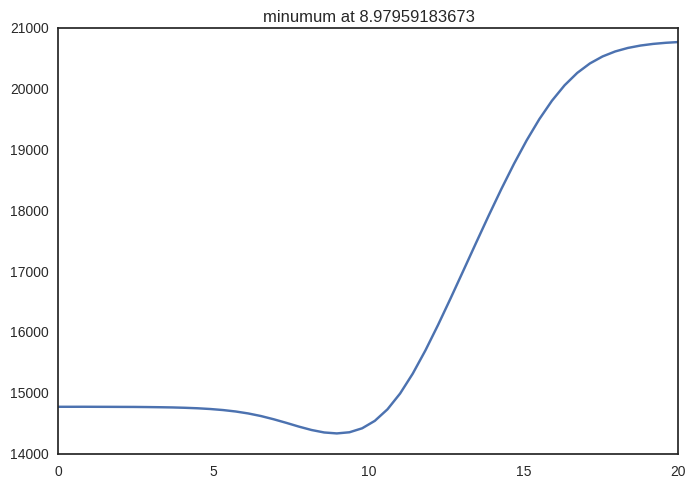

In [5]:
plt.plot(alphas, scores)
plt.title('minumum at ' + str(alphas[np.argmin(scores)]));

Here the optimal $\alpha$ is outside of default interval...

### HOAG - NO BOUNDS ON $\alpha$

In [6]:
identity = lambda x: x
clf, res = mlx.hoag_fit(dataset, alpha0=0., projection=identity, max_iter=10)


started hoag

Log step 0
-------------------  -----------
training error       1.20545e+06
validation error     1.21458e+06
test error           1.22281e+06
validation accuracy  0.5034
test accuracy        0.5021
alpha                0
der alpha            0
step size            0
-------------------  -----------
inner level iterations: 145, inner objective 13627.3177499, grad norm 255.0809048024641
Inverting matrix with precision 9.975771591495612
increased step size
it 1, g: 14733.7494336, incr: -inf, sum lambda 1.0, epsilon: 0.0009000000000000001, L: 17.0194808665, norm grad_lambda: 17.9152430174

Log step 1
-------------------  -------------
training error       13627.3
validation error     14733.7
test error           14752.7
validation accuracy      0.772867
test accuracy            0.775467
alpha                    1
der alpha              -17.9152
step size                0.0558184
-------------------  -------------
inner level iterations: 0, inner objective 13642.7134656, grad

ValueError: array must not contain infs or NaNs

Without bounds the algorithm diverges... But here the step size looks kind of too big... Shouldn't it decrease?

### HOAG WITH $\alpha \in [-10, 10]$

In [7]:
proj = lambda x: np.minimum(np.maximum(x, -10.), 10.)
clf2, res2 = mlx.hoag_fit(dataset, alpha0=0., projection=proj, max_iter=100)

started hoag

Log step 0
-------------------  -----------
training error       1.1146e+06
validation error     1.13231e+06
test error           1.13028e+06
validation accuracy  0.501167
test accuracy        0.498267
alpha                0
der alpha            0
step size            0
-------------------  -----------
inner level iterations: 130, inner objective 13631.4713413, grad norm 198.52092129127848
Inverting matrix with precision 9.977236433283112
increased step size
it 1, g: 14729.8013085, incr: -inf, sum lambda 1.0, epsilon: 0.0009000000000000001, L: 23.2439660711, norm grad_lambda: 24.4673327064

Log step 1
-------------------  -------------
training error       13631.5
validation error     14729.8
test error           14748.7
validation accuracy      0.7724
test accuracy            0.7753
alpha                    1
der alpha              -24.4673
step size                0.0408708
-------------------  -------------
inner level iterations: 0, inner objective 13652.4962286, grad

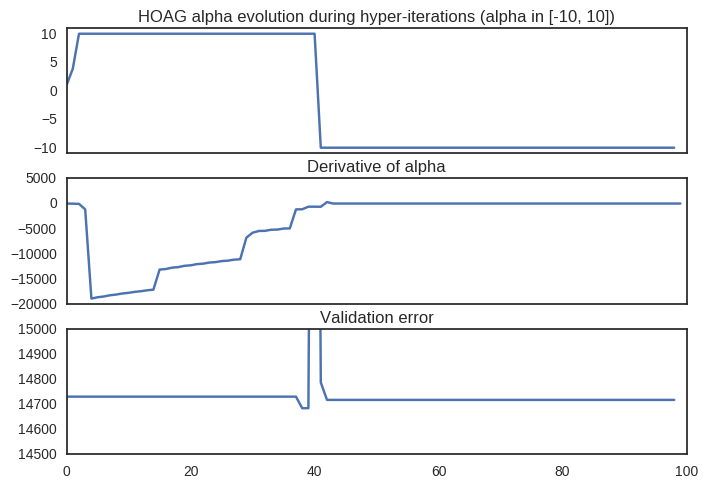

In [12]:
fig, ax = plt.subplots(nrows=3, sharex=True)
ax[0].plot(res2['alpha'][1:])
ax[0].set_ylim(-11, 11)
ax[0].set_title('HOAG alpha evolution during hyper-iterations (alpha in [-10, 10])')
ax[1].plot(res2['der alpha'])
ax[1].set_title('Derivative of alpha')

ax[2].set_ylim(14500, 15000)
ax[2].plot(res2['validation error'][1:])
ax[2].set_title('Validation error');  # the one we're optimizing

Strange thing here is that the derivative w.r.t. $\alpha$ remains quite negative even when it is 10... Could this be changed/avoided with a different $\epsilon$ devrease strategy?